In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.axes
import json

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, relationship
from sqlalchemy import create_engine, func, inspect,desc, distinct

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

In [6]:
connection = engine.connect()
result= connection.execute('SELECT station, date, prcp, tobs FROM measurement')
result

In [7]:
# Design a query to retrieve the last 12 months of precipitation data
# DF has 
Measurement_Table=Base.classes.measurement
query = session.query(Measurement_Table.date, Measurement_Table.prcp)
df=pd.read_sql(query.statement, engine)
df.set_index('date',inplace=True)
df.sort_values(['date'], ascending=[False])
df.head()

,prcp
date,
2010-01-01,0.08
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-06,NaN


In [8]:
# Total precipitation at all stations for each date (Extra scratch work)
df_2=df
df_2.reset_index()
len(df_2.groupby(['date'])['prcp'].sum())

2792

In [9]:
# Summary Stats for Precipitation
df['prcp'].describe()

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

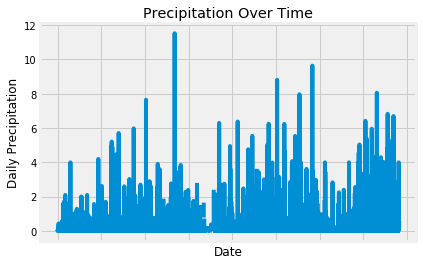

In [10]:
x=np.arange(0,len(df['prcp']),1);
y = df['prcp']
plt.plot(x, y)
plt.title("Precipitation Over Time")
plt.ylabel('Daily Precipitation')
plt.xlabel('Date')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

In [11]:
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores


In [12]:
# Station Analysis
# Design a query to calculate the total number of stations
Station_Table=Base.classes.station
query = session.query(Station_Table.name, Station_Table.station)
df_a=pd.read_sql(query.statement, engine)
#df.set_index('date',inplace=True)
#df.sort_values(['date'], ascending=[False])
station_count = df_a['name'].nunique()

print(f'There are {station_count} total stations.')
df_a

There are 9 total stations.


,name,station
0,"WAIKIKI 717.2, HI US",USC00519397
1,"KANEOHE 838.1, HI US",USC00513117
2,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830
3,"PEARL CITY, HI US",USC00517948
4,"UPPER WAHIAWA 874.3, HI US",USC00518838
5,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523
6,"WAIHEE 837.5, HI US",USC00519281
7,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918
8,"MANOA LYON ARBO 785.2, HI US",USC00516128


In [13]:
# Most active stations query
Measurement_Table=Base.classes.measurement
Station_Table=Base.classes.station
query = session.query(Measurement_Table.station, Measurement_Table.prcp)
df_b=pd.read_sql(query.statement, engine)
df_c = pd.merge(df_b,df_a, on = 'station')
df_b['station'].value_counts()
df_c['name'].value_counts()


WAIHEE 837.5, HI US                       2772
WAIKIKI 717.2, HI US                      2724
KANEOHE 838.1, HI US                      2709
WAIMANALO EXPERIMENTAL FARM, HI US        2669
MANOA LYON ARBO 785.2, HI US              2612
KUALOA RANCH HEADQUARTERS 886.9, HI US    2202
HONOLULU OBSERVATORY 702.2, HI US         1979
PEARL CITY, HI US                         1372
UPPER WAHIAWA 874.3, HI US                 511
Name: name, dtype: int64

In [14]:
Measurement_Table=Base.classes.measurement
Station_Table=Base.classes.station
query = session.query(Measurement_Table.station, func.max(Measurement_Table.prcp))
df_d=pd.read_sql(query.statement, engine)
df_d

,station,max_1
0,USC00514830,11.53


In [15]:
# Station with highest number of observations
named_measurements = relationship \
('Measurement', primaryjoin='foreign(Measurement.station)\
==remote(Station.station)')

query = session.query(Station_Table.name,Measurement_Table.station, func.max(Measurement_Table.prcp))
df_e=pd.read_sql(query.statement, engine)
df_e

,name,station,max_1
0,"WAIKIKI 717.2, HI US",USC00514830,11.53


In [16]:

# Create query for all tobs data in descending order. Drop date duplicates    
query = session.query(Measurement_Table.date,Station_Table.name, \
        Measurement_Table.station, Measurement_Table.tobs).filter(\
         Measurement_Table.date).order_by(desc('date'))
df_f=pd.read_sql(query.statement, engine)
df_g=df_f.drop_duplicates('date').reset_index(drop=True)
df_g.head()

,date,name,station,tobs
0,2017-08-23,"WAIKIKI 717.2, HI US",USC00519397,81.0
1,2017-08-22,"WAIKIKI 717.2, HI US",USC00519397,82.0
2,2017-08-21,"WAIKIKI 717.2, HI US",USC00519397,81.0
3,2017-08-20,"WAIKIKI 717.2, HI US",USC00519397,81.0
4,2017-08-19,"WAIKIKI 717.2, HI US",USC00519397,79.0


In [17]:
# Identify which date is in the 365th row \
# (since duplicates have been dropped)
days_ago=365
df_g.iloc[days_ago]
date_one_year_ago=df_g.loc[days_ago,"date"]
date_one_year_ago

'2016-08-23'

In [18]:
# Select last row to determine final record 

obs_x= df_f.loc[df_f['date']== date_one_year_ago].tail(1)
row_count_obs_x=obs_x.index.item()
row_count_obs_x

20069

In [19]:
query = session.query(Measurement_Table.date,Station_Table.name, \
        Measurement_Table.station, Measurement_Table.tobs).filter(\
         Measurement_Table.date).order_by(desc('date')).limit(row_count_obs_x)
df_h=pd.read_sql(query.statement, engine)
df_h.head()

,date,name,station,tobs
0,2017-08-23,"WAIKIKI 717.2, HI US",USC00519397,81.0
1,2017-08-23,"KANEOHE 838.1, HI US",USC00519397,81.0
2,2017-08-23,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00519397,81.0
3,2017-08-23,"PEARL CITY, HI US",USC00519397,81.0
4,2017-08-23,"UPPER WAHIAWA 874.3, HI US",USC00519397,81.0


In [20]:
df_h['name'].value_counts()

WAIHEE 837.5, HI US                       2230
WAIMANALO EXPERIMENTAL FARM, HI US        2230
UPPER WAHIAWA 874.3, HI US                2230
KUALOA RANCH HEADQUARTERS 886.9, HI US    2230
HONOLULU OBSERVATORY 702.2, HI US         2230
PEARL CITY, HI US                         2230
WAIKIKI 717.2, HI US                      2230
KANEOHE 838.1, HI US                      2230
MANOA LYON ARBO 785.2, HI US              2229
Name: name, dtype: int64

In [21]:
#  Convert the query results to a Dictionary using `date` \
# as the key and `prcp` as the value.
query = session.query(Measurement_Table.date, Measurement_Table.prcp)
df_i=pd.read_sql(query.statement, engine)

date_prcp_dict = df_i.to_dict()
json_dict=json.dumps(date_prcp_dict)
json_dict


'{"date": {"0": "2010-01-01", "1": "2010-01-02", "2": "2010-01-03", "3": "2010-01-04", "4": "2010-01-06", "5": "2010-01-07", "6": "2010-01-08", "7": "2010-01-09", "8": "2010-01-10", "9": "2010-01-11", "10": "2010-01-12", "11": "2010-01-14", "12": "2010-01-15", "13": "2010-01-16", "14": "2010-01-17", "15": "2010-01-18", "16": "2010-01-19", "17": "2010-01-20", "18": "2010-01-21", "19": "2010-01-22", "20": "2010-01-23", "21": "2010-01-24", "22": "2010-01-25", "23": "2010-01-26", "24": "2010-01-27", "25": "2010-01-28", "26": "2010-01-30", "27": "2010-01-31", "28": "2010-02-01", "29": "2010-02-03", "30": "2010-02-04", "31": "2010-02-05", "32": "2010-02-06", "33": "2010-02-07", "34": "2010-02-08", "35": "2010-02-09", "36": "2010-02-11", "37": "2010-02-12", "38": "2010-02-13", "39": "2010-02-14", "40": "2010-02-15", "41": "2010-02-16", "42": "2010-02-17", "43": "2010-02-19", "44": "2010-02-20", "45": "2010-02-21", "46": "2010-02-22", "47": "2010-02-23", "48": "2010-02-24", "49": "2010-02-25",

In [22]:
# Return a JSON list of stations from the dataset.
query = session.query(Station_Table.station,Station_Table.name)
df_j=pd.read_sql(query.statement, engine)
station_name_dict = df_j.to_dict()
json_stations=json.dumps(station_name_dict)
json_stations

'{"station": {"0": "USC00519397", "1": "USC00513117", "2": "USC00514830", "3": "USC00517948", "4": "USC00518838", "5": "USC00519523", "6": "USC00519281", "7": "USC00511918", "8": "USC00516128"}, "name": {"0": "WAIKIKI 717.2, HI US", "1": "KANEOHE 838.1, HI US", "2": "KUALOA RANCH HEADQUARTERS 886.9, HI US", "3": "PEARL CITY, HI US", "4": "UPPER WAHIAWA 874.3, HI US", "5": "WAIMANALO EXPERIMENTAL FARM, HI US", "6": "WAIHEE 837.5, HI US", "7": "HONOLULU OBSERVATORY 702.2, HI US", "8": "MANOA LYON ARBO 785.2, HI US"}}'

In [23]:
# query for the dates and temperature observations from a year from the last data point.

one_to_two_years_ago = dt.timedelta(days=days_ago) - dt.timedelta(days=(days_ago))
one_to_two_years_ago


datetime.timedelta(0)

In [24]:
query_date = dt.date(2016,8,23) - dt.timedelta(days=365)
print("Query Date: ", query_date)


Query Date:  2015-08-24


In [33]:
query = session.query(Measurement_Table.date,Measurement_Table.tobs)\
.filter(Measurement_Table.date>=query_date)
df_k=pd.read_sql(query.statement, engine)
date_tobs_dict = df_k.to_dict()
json_tobs=json.dumps(date_tobs_dict)
json_tobs

'{"date": {"0": "2015-08-24", "1": "2015-08-25", "2": "2015-08-26", "3": "2015-08-27", "4": "2015-08-28", "5": "2015-08-29", "6": "2015-08-30", "7": "2015-08-31", "8": "2015-09-01", "9": "2015-09-02", "10": "2015-09-03", "11": "2015-09-04", "12": "2015-09-05", "13": "2015-09-06", "14": "2015-09-07", "15": "2015-09-08", "16": "2015-09-09", "17": "2015-09-10", "18": "2015-09-11", "19": "2015-09-12", "20": "2015-09-13", "21": "2015-09-14", "22": "2015-09-15", "23": "2015-09-16", "24": "2015-09-17", "25": "2015-09-18", "26": "2015-09-19", "27": "2015-09-20", "28": "2015-09-21", "29": "2015-09-22", "30": "2015-09-23", "31": "2015-09-24", "32": "2015-09-25", "33": "2015-09-26", "34": "2015-09-27", "35": "2015-09-28", "36": "2015-09-29", "37": "2015-09-30", "38": "2015-10-01", "39": "2015-10-02", "40": "2015-10-03", "41": "2015-10-04", "42": "2015-10-05", "43": "2015-10-06", "44": "2015-10-07", "45": "2015-10-08", "46": "2015-10-09", "47": "2015-10-10", "48": "2015-10-11", "49": "2015-10-12",

In [48]:
# Return a JSON list of the minimum temperature, the average temperature, \
# and the max temperature for a given start or start-end range.

query = session.query(func.max(Measurement_Table.tobs).label('max temp'),\
                      func.min(Measurement_Table.tobs).label('min temp'),\
                      func.avg(Measurement_Table.tobs).label('avg temp')).filter(Measurement_Table.date>=query_date)
df_l=pd.read_sql(query.statement, engine)
df_l
max_min_avg_tobs_list = df_l.iloc[0].tolist()
json_metrics=json.dumps(max_min_avg_tobs_list)
json_metrics

'[87.0, 56.0, 74.50711626888548]'

In [53]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

# Same Output as above . Using starter code for this bullet point
# Which asks for start_date only.
def calc_temps(start_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.max(Measurement.tobs),func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).all()

# function usage example
print(calc_temps('2015-08-24'))

[(87.0, 56.0, 74.50711626888548)]


In [55]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.max(Measurement.tobs),func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2015-08-24', '2016-08-23'))

[(86.0, 56.0, 74.43899317406144)]


In [ ]:
############ Code / Data Below Provided In Starter File, along with def calc_temps ##############

# Exploratory Climate Analysis

In [1]:
# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?


[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


[(54.0, 85.0, 71.66378066378067)]

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


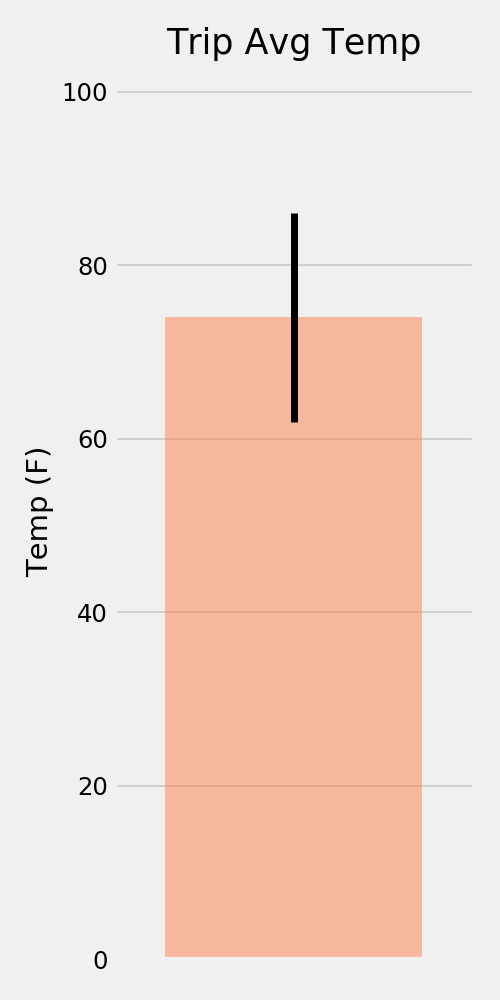

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


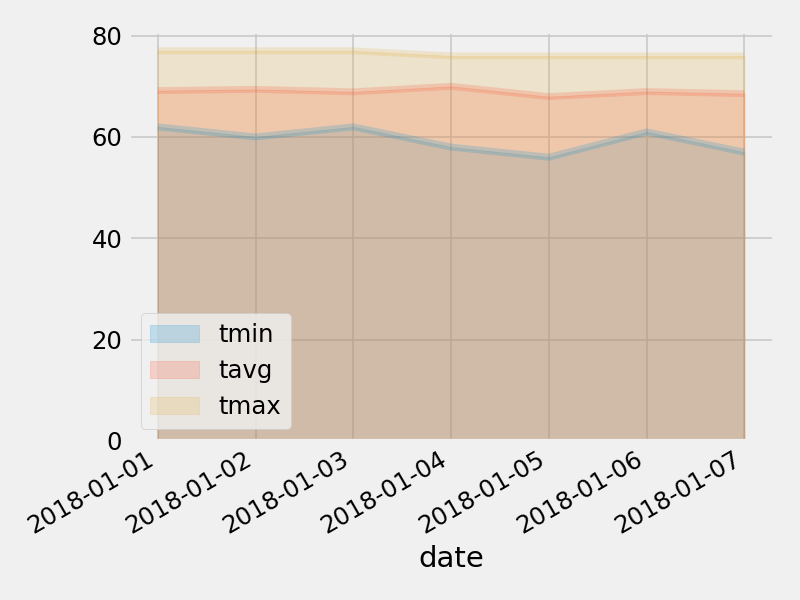

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
